In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [135]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


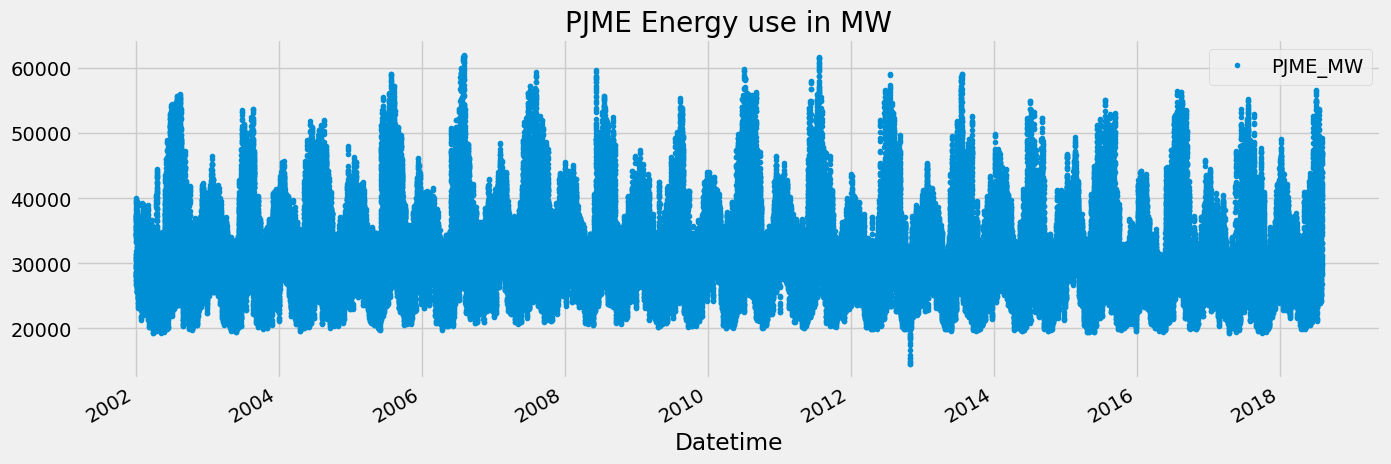

In [136]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title="PJME Energy use in MW")
plt.show()

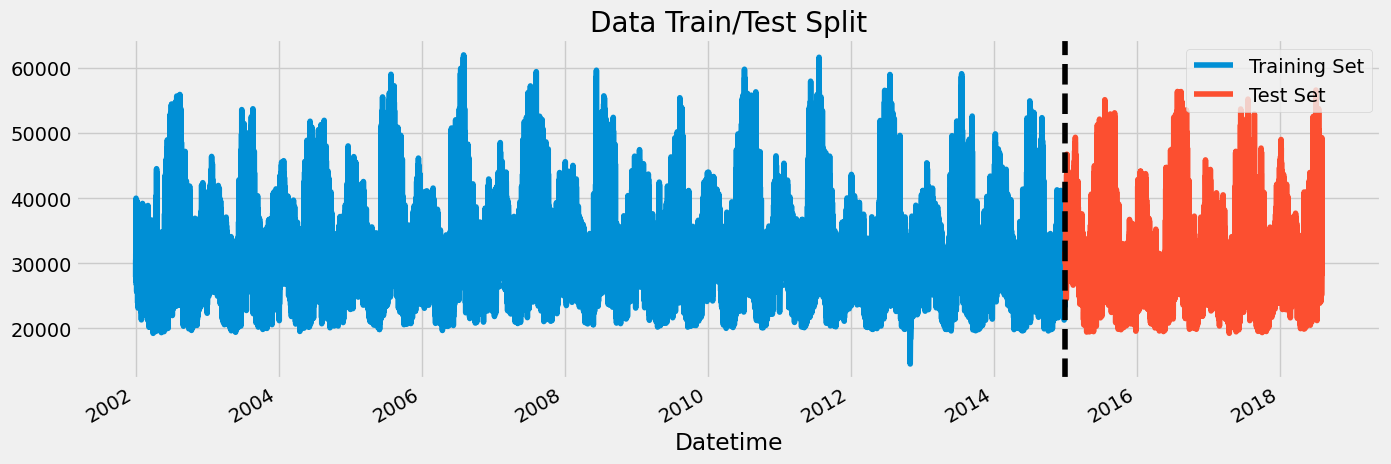

In [137]:
#spliting
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


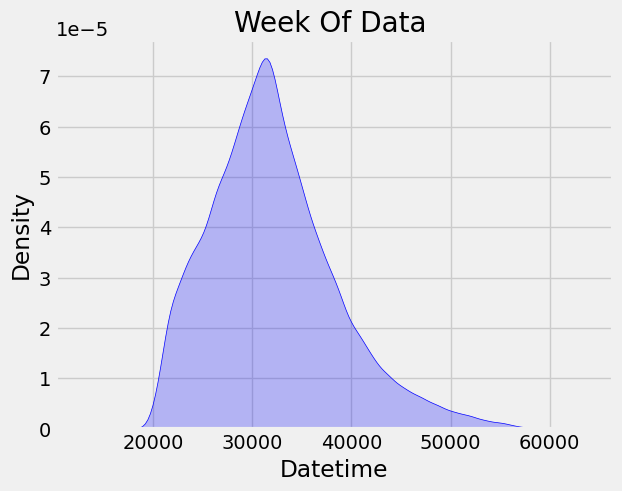

In [147]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]
sns.kdeplot(df['PJME_MW'], fill=True, color='blue')
plt.title('Week Of Data ')
plt.xlabel('Datetime')
plt.ylabel('Density')
plt.show()

In [148]:
df.index.hour

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
       15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
      dtype='int32', name='Datetime', length=145366)

In [149]:
#FEAtURE CREATION
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)
df.head(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
2002-12-31 06:00:00,26222.0,6,1,4,12,2002,365,31,1
2002-12-31 07:00:00,28702.0,7,1,4,12,2002,365,31,1
2002-12-31 08:00:00,30698.0,8,1,4,12,2002,365,31,1
2002-12-31 09:00:00,31800.0,9,1,4,12,2002,365,31,1


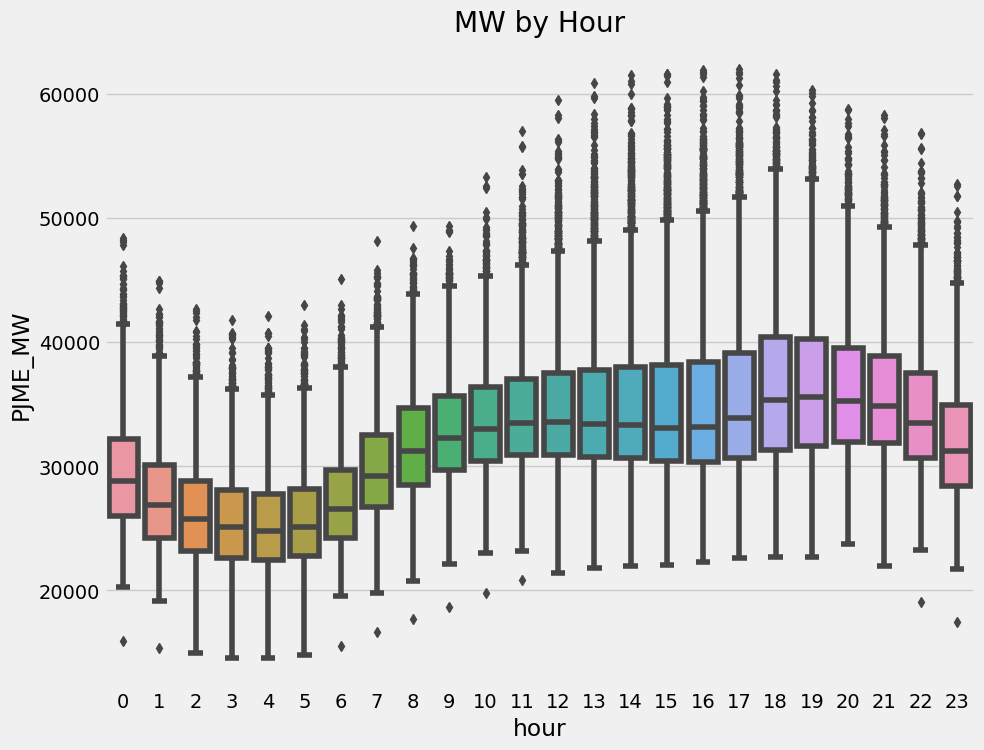

In [150]:
#Visualize our Feature / Target Relationship
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

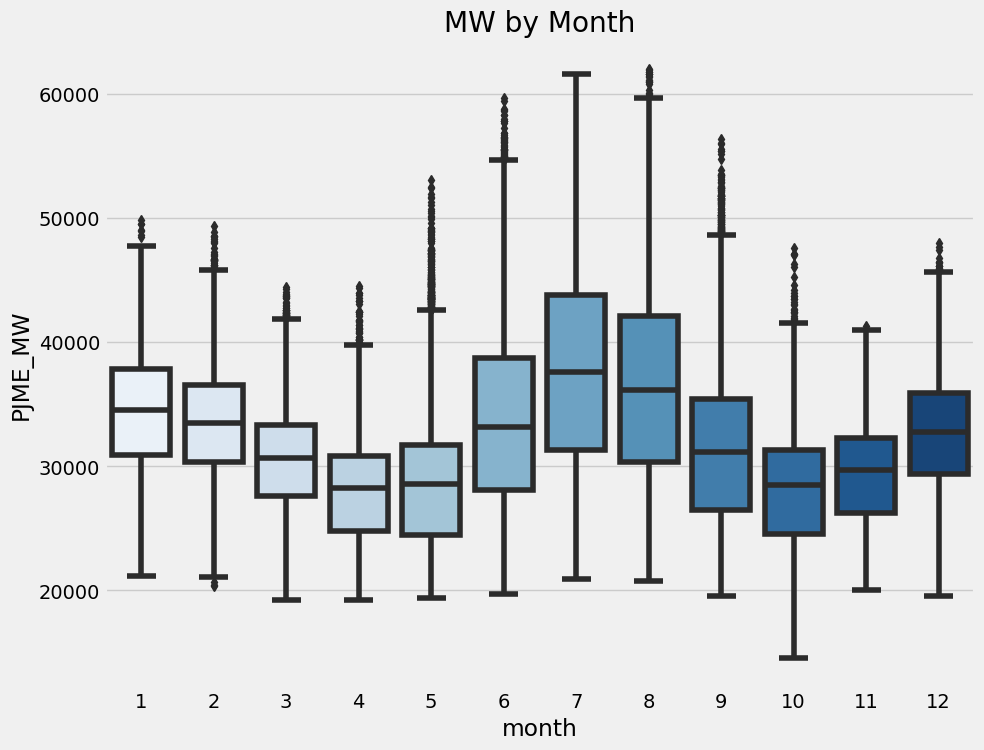

In [151]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [153]:
#ROBUST MODELLLLLLLLLLL💪💪💪
from sklearn.model_selection import train_test_split, RandomizedSearchCV

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Hyperparameter optimization using RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#RandomizedSearchCV
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

reg = xgb.XGBRegressor(**best_params)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=100
)


y_pred = reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 1500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0]	validation_0-rmse:5960.23142	validation_1-rmse:5906.72986


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:2004.75076	validation_1-rmse:2196.89634
[200]	validation_0-rmse:1617.21897	validation_1-rmse:1884.97353
[300]	validation_0-rmse:1324.40821	validation_1-rmse:1664.30380
[400]	validation_0-rmse:1130.80971	validation_1-rmse:1510.89334
[500]	validation_0-rmse:1011.73837	validation_1-rmse:1429.91626
[600]	validation_0-rmse:900.54339	validation_1-rmse:1354.07691
[700]	validation_0-rmse:828.96733	validation_1-rmse:1310.83202
[800]	validation_0-rmse:754.59878	validation_1-rmse:1270.67169
[900]	validation_0-rmse:700.90085	validation_1-rmse:1240.09967
[1000]	validation_0-rmse:649.48204	validation_1-rmse:1211.89367
[1100]	validation_0-rmse:606.14383	validation_1-rmse:1188.82275
[1200]	validation_0-rmse:567.24434	validation_1-rmse:1168.66190
[1300]	validation_0-rmse:537.39390	validation_1-rmse:1153.30404
[1400]	validation_0-rmse:509.01300	validation_1-rmse:1139.19553
[1499]	validation_0-rmse:478.52563	validation_1-rmse:1124.46691
Test RMSE: 4438.3557366505875


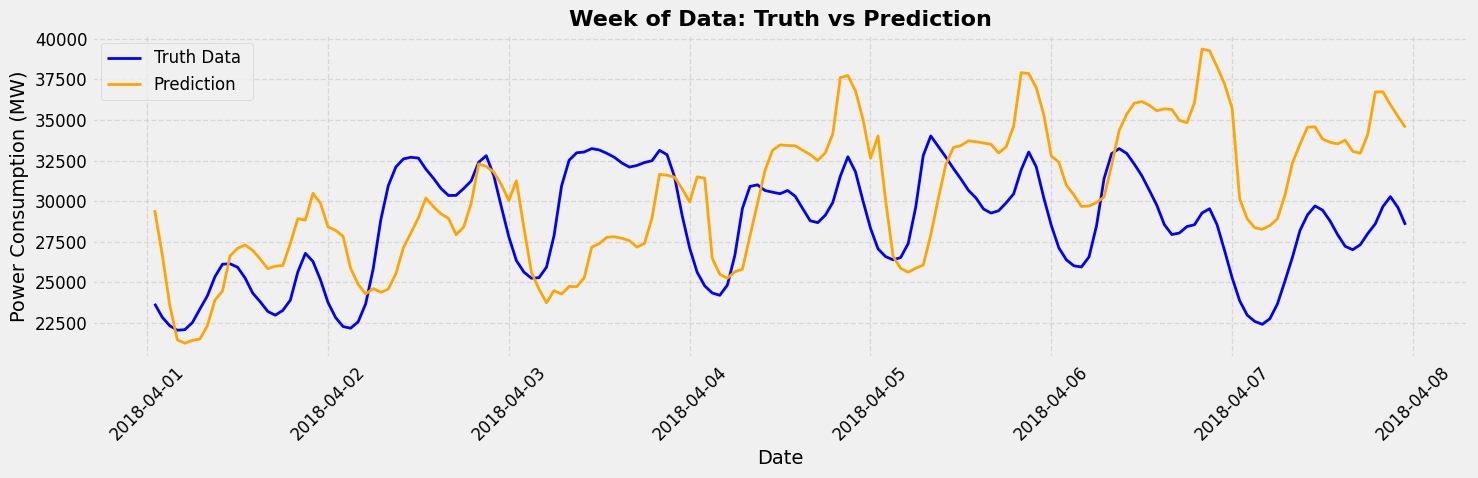

In [163]:
#prediction PLOTING
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Week of Data: Truth vs Prediction', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Power Consumption (MW)', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

ax.plot(subset_df.index, smooth_truth, color='blue', linewidth=2, label='Truth Data ')
ax.plot(subset_df.index, smooth_pred, linestyle='-', color='orange', linewidth=2, label='Prediction')

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

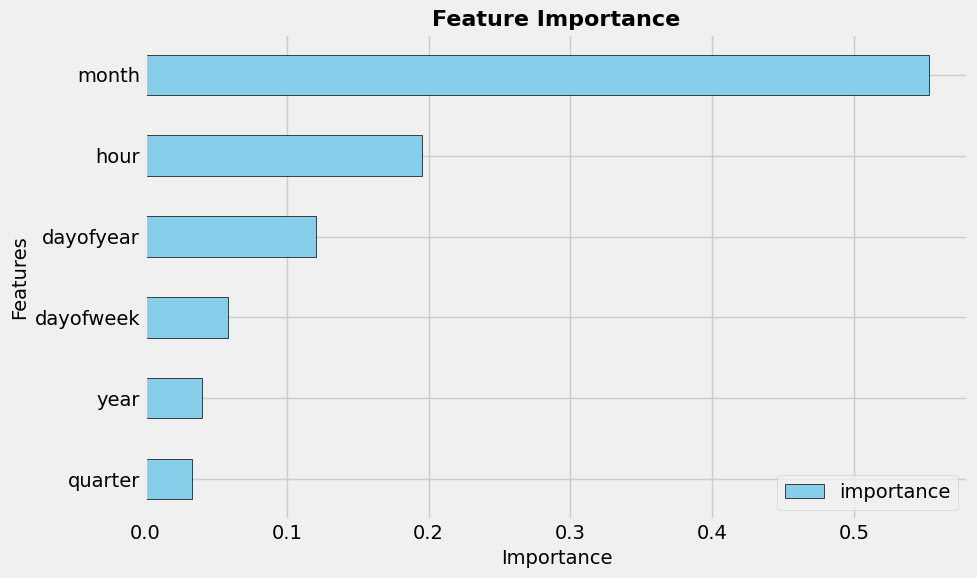

In [164]:
#FEAture IMPORTANCCE
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi_sorted = fi.sort_values('importance')
fi_sorted.plot(kind='barh', title='Feature Importance', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

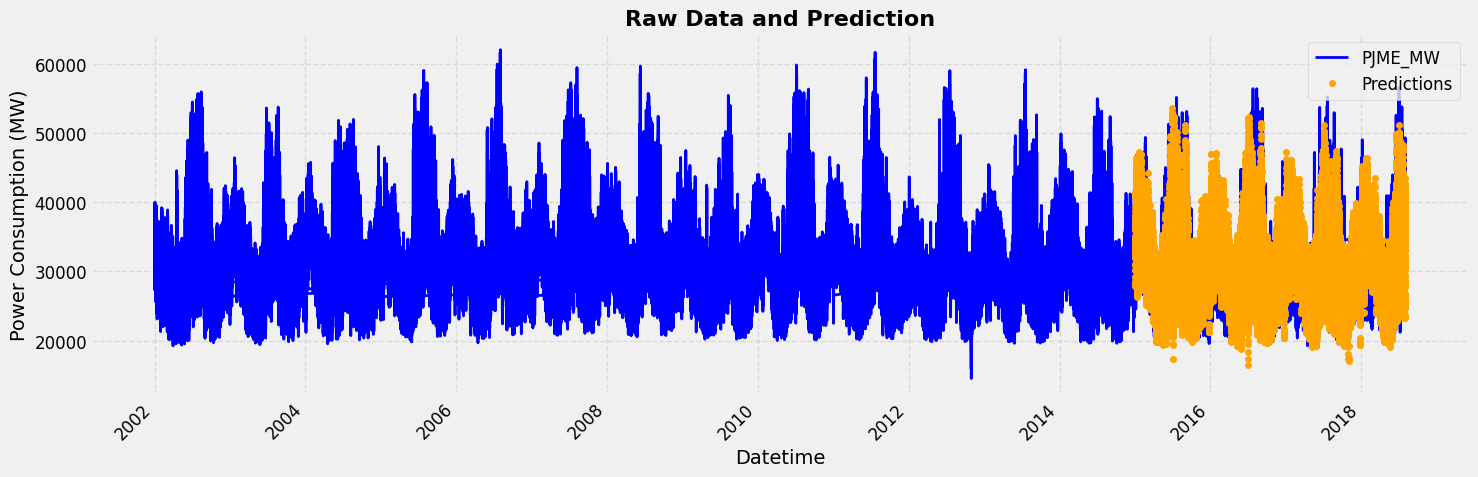

In [173]:
#prediction
test['prediction_new'] = reg.predict(X_test)

df = df.merge(test[['prediction_new']], how='left', left_index=True, right_index=True, suffixes=('', '_new'))

fig, ax = plt.subplots(figsize=(15, 5))
df[['PJME_MW']].plot(ax=ax, color='blue', linewidth=2, label='Truth Data')
df['prediction_new'].plot(ax=ax, style='.', color='orange', markersize=8, label='Predictions')
ax.set_title('Raw Data and Prediction', fontsize=16, fontweight='bold')
ax.set_xlabel('Datetime', fontsize=14)
ax.set_ylabel('Power Consumption (MW)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

RMSE Score on Test set: 4438.36


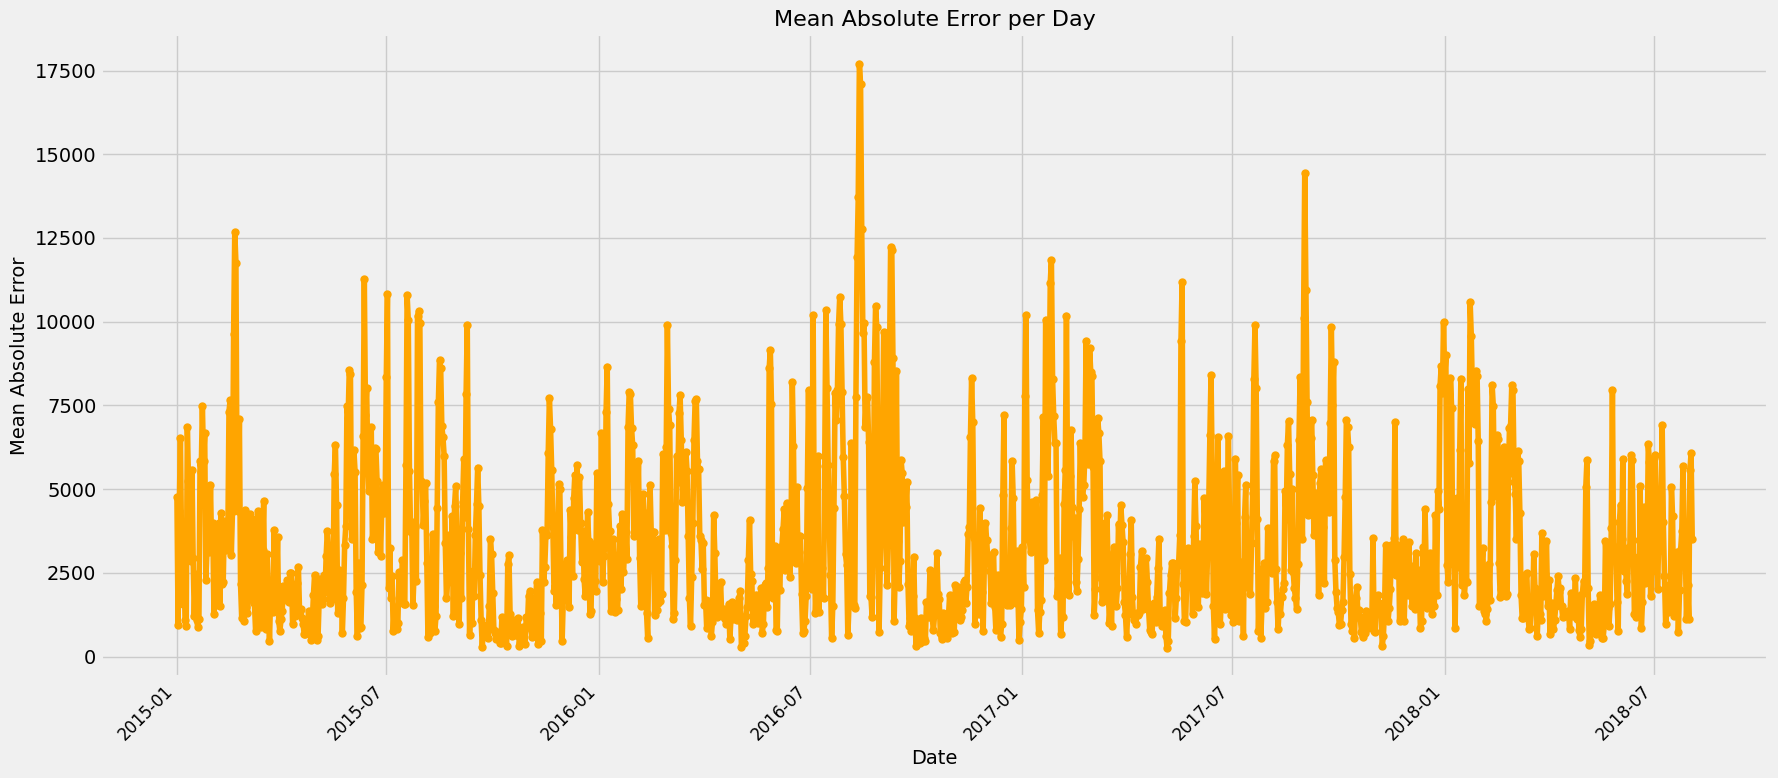

date
2016-08-13    17709.072998
2016-08-14    17095.266764
2017-09-02    14427.645589
2016-08-12    13712.722493
2016-08-15    12776.047607
2015-02-20    12668.711182
2016-09-09    12219.032389
2016-09-10    12131.515544
2016-08-11    11921.052979
2017-01-26    11845.297038
Name: error, dtype: float64


In [177]:
#score-rmse(plot also)
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction_new']))
print(f'RMSE Score on Test set: {score:0.2f}')

test['error'] = np.abs(test['PJME_MW'] - test['prediction_new'])

test['date'] = test.index.date

mean_error_per_day = test.groupby(['date'])['error'].mean()
plt.figure(figsize=(18, 8))  
plt.plot(mean_error_per_day.index, mean_error_per_day.values, marker='o', color='orange', linestyle='-', markersize=5)
plt.title('Mean Absolute Error per Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()
print(mean_error_per_day.sort_values(ascending=False).head(10))